In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# Load the data
df = pd.read_csv('Sales analytics.csv')


In [ ]:
# View the data
print(df.head())
print(df.info())
print(df.describe())



  CustomerID                         CompanyName         ContactName  \
0      ALFKI                 Alfreds Futterkiste        Maria Anders   
1      ANATR  Ana Trujillo Emparedados y helados        Ana Trujillo   
2      ANTON             Antonio Moreno Taquería      Antonio Moreno   
3      AROUT                     Around the Horn        Thomas Hardy   
4      BERGS                  Berglunds snabbköp  Christina Berglund   

           ContactTitle                        Address         City Region  \
0  Sales Representative                  Obere Str. 57       Berlin    NaN   
1                 Owner  Avda. de la Constitución 2222  México D.F.    NaN   
2                 Owner                Mataderos  2312  México D.F.    NaN   
3  Sales Representative                120 Hanover Sq.       London    NaN   
4   Order Administrator                Berguvsvägen  8        Luleå    NaN   

  PostalCode  Country           Phone  ...                ContactName.1  \
0      12209  Germany  

In [ ]:
# Handle missing values
print(df.isnull().sum())


CustomerID      2064
CompanyName     2064
ContactName     2064
ContactTitle    2064
Address         2064
                ... 
PostalCode.2    2126
Country.2       2126
Phone.2         2126
Fax.1           2142
HomePage        2150
Length: 73, dtype: int64


In [ ]:
#1.What are the key factors influencing customer retention or loyalty based on the dataset?
# Convert date columns to datetime
date_columns = ['OrderDate', 'RequiredDate', 'ShippedDate']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [ ]:
# Remove duplicates if any
df.drop_duplicates(inplace=True)

In [ ]:
# Drop missing values and create a clean copy
df = df.dropna(subset=['OrderDate', 'CustomerID', 'OrderID', 'UnitPrice', 'Quantity']).copy()

# Now assign safely
df['TotalPrice'] = df['UnitPrice'] * df['Quantity'] * (1 - df['Discount'])


In [ ]:
# Recency: Days since last purchase
snapshot_date = df['OrderDate'].max()
rfm = df.groupby('CustomerID').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days,
    'OrderID': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [ ]:
# Display RFM table
print("\n--- RFM Table ---")
print(rfm.head())


--- RFM Table ---
  CustomerID  Recency  Frequency  Monetary
0      ALFKI      113          1     168.0
1      ANATR      112          1      98.0
2      ANTON      109          1     174.0
3      AROUT      109          1     167.4
4      BERGS      108          1    1696.0


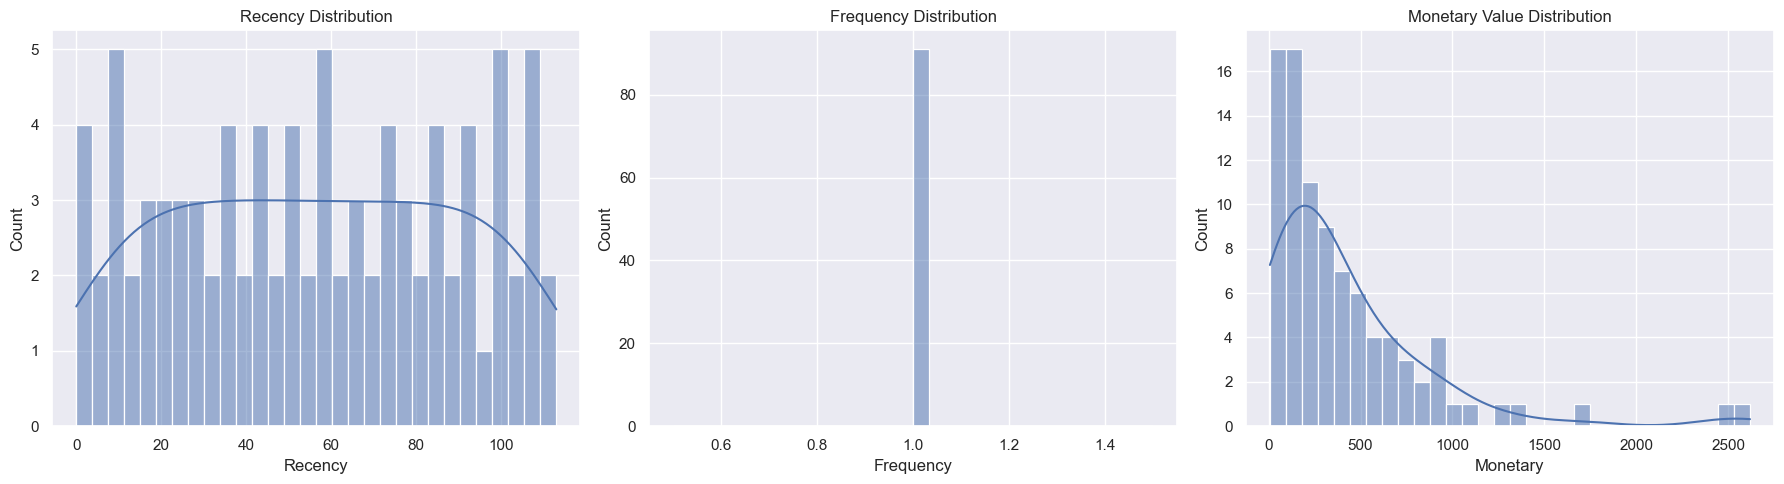

In [ ]:
# 1. Distribution of RFM metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], kde=True)
axes[2].set_title('Monetary Value Distribution')

plt.tight_layout()
plt.show()

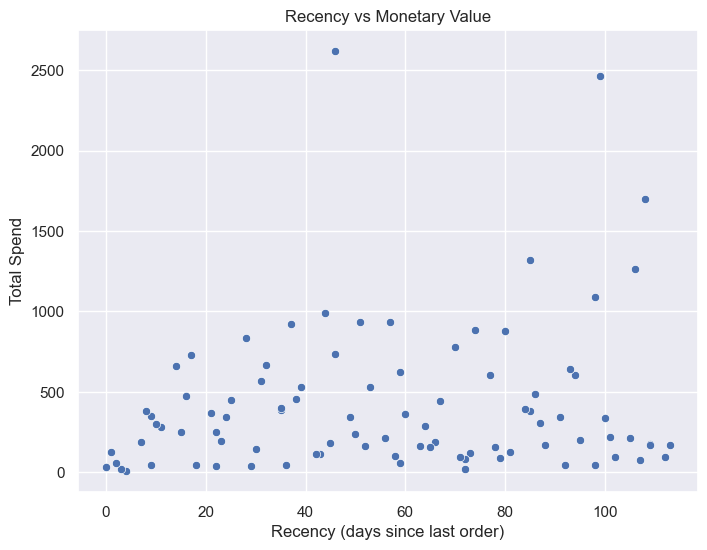

In [ ]:
# 2. Recency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary')
plt.title("Recency vs Monetary Value")
plt.xlabel("Recency (days since last order)")
plt.ylabel("Total Spend")
plt.show()


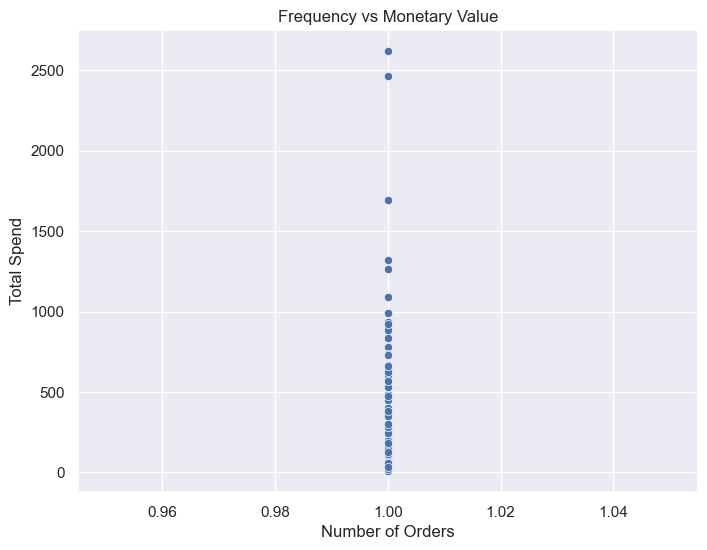

In [ ]:
# 3. Frequency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary')
plt.title("Frequency vs Monetary Value")
plt.xlabel("Number of Orders")
plt.ylabel("Total Spend")
plt.show()


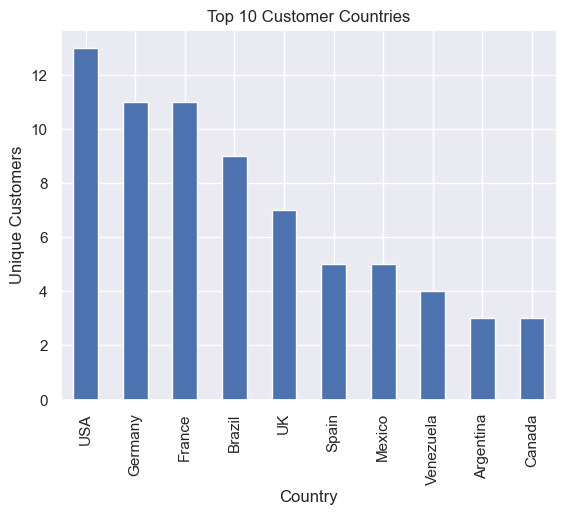

In [ ]:
# Top 10 countries by customer count
if 'Country' in df.columns:
    top_countries = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head(10)
    top_countries.plot(kind='bar', title="Top 10 Customer Countries")
    plt.ylabel("Unique Customers")
    plt.show()

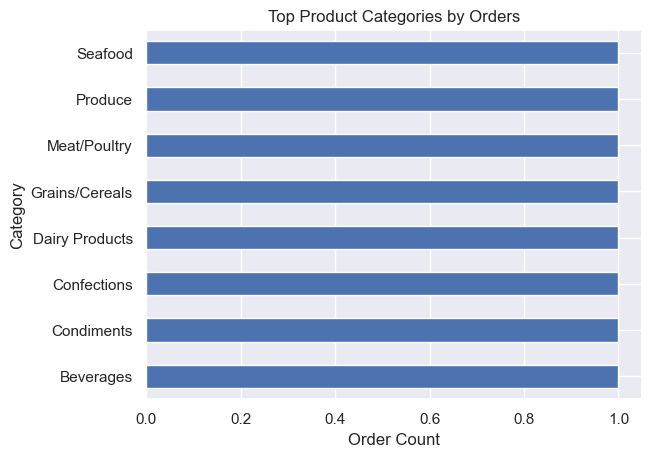

In [ ]:
# Top product categories (if available)
if 'CategoryName' in df.columns:
    top_categories = df.groupby('CategoryName')['OrderID'].nunique().sort_values(ascending=False).head(10)
    top_categories.plot(kind='barh', title="Top Product Categories by Orders")
    plt.xlabel("Order Count")
    plt.ylabel("Category")
    plt.show()

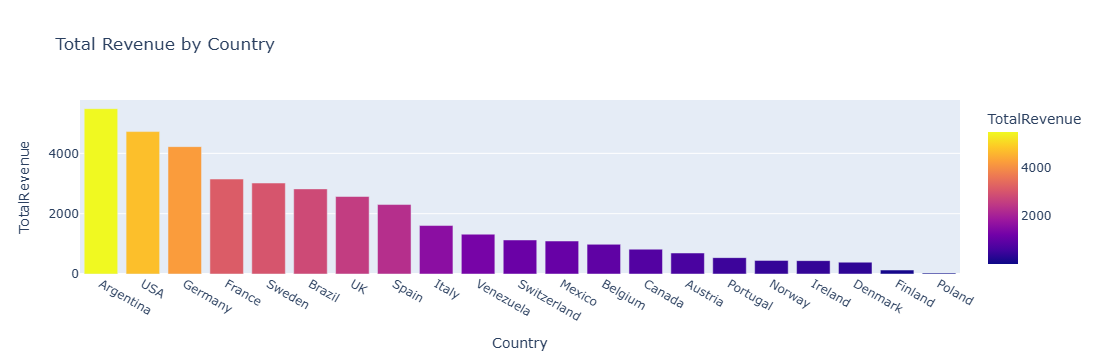

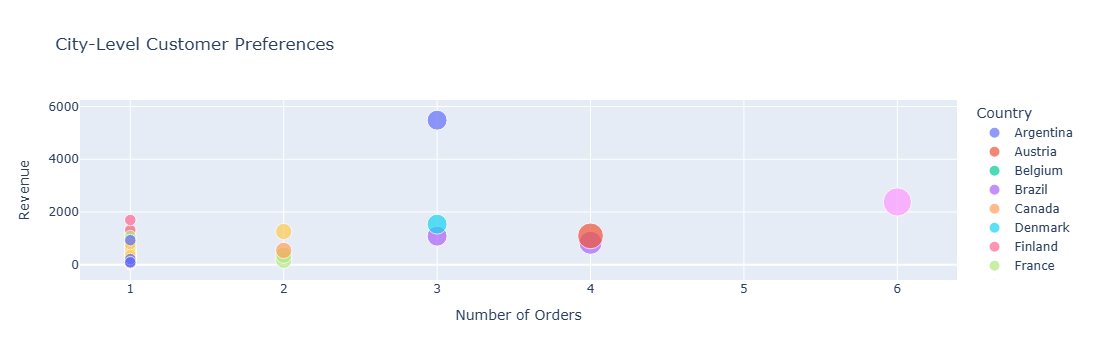

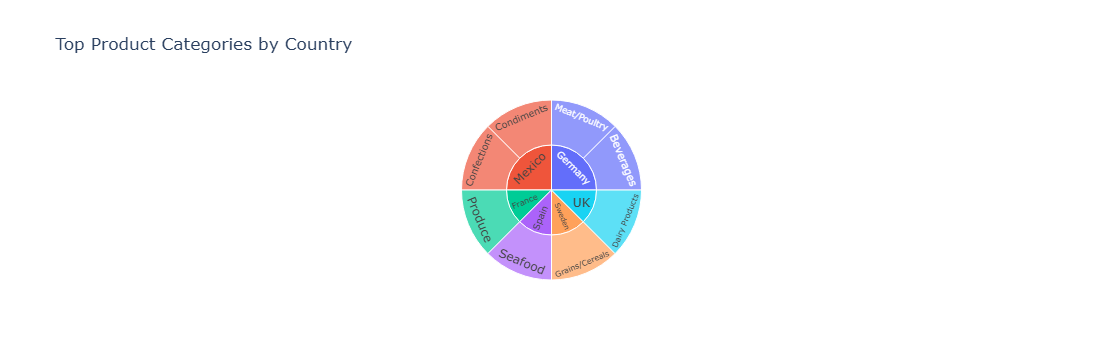

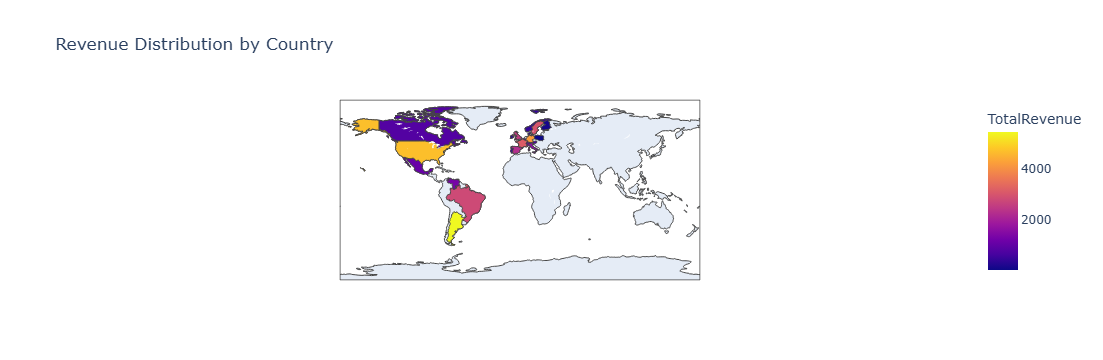

In [ ]:
#2.How do customer preferences vary based on their location or demographics? Can we explore this through interactive visualizations?
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load dataset
df = pd.read_csv("Sales analytics.csv")

# Convert dates
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')
df['ShippedDate'] = pd.to_datetime(df['ShippedDate'], errors='coerce')

# Drop rows with missing key values and copy
df = df.dropna(subset=['OrderDate', 'CustomerID', 'OrderID', 'UnitPrice', 'Quantity', 'Country']).copy()

# Calculate total price per order item
df['TotalPrice'] = df['UnitPrice'] * df['Quantity'] * (1 - df['Discount'])

# ------------------------------------------
# 📍 Analysis 1: Spending by Country
# ------------------------------------------
country_stats = df.groupby('Country').agg({
    'CustomerID': pd.Series.nunique,
    'OrderID': 'nunique',
    'TotalPrice': 'sum'
}).reset_index().rename(columns={
    'CustomerID': 'UniqueCustomers',
    'OrderID': 'TotalOrders',
    'TotalPrice': 'TotalRevenue'
})

# Interactive bar chart: Revenue by Country
fig = px.bar(country_stats.sort_values('TotalRevenue', ascending=False),
             x='Country', y='TotalRevenue',
             color='TotalRevenue', title='Total Revenue by Country')
fig.show()

# ------------------------------------------
# 📍 Analysis 2: Frequency and Monetary by Region/City
# ------------------------------------------
geo_group = df.groupby(['Country', 'City']).agg({
    'CustomerID': pd.Series.nunique,
    'OrderID': 'nunique',
    'TotalPrice': 'sum'
}).reset_index().rename(columns={
    'CustomerID': 'UniqueCustomers',
    'OrderID': 'TotalOrders',
    'TotalPrice': 'TotalRevenue'
})

# Interactive bubble chart: Orders vs Revenue by City
fig = px.scatter(geo_group, x='TotalOrders', y='TotalRevenue',
                 size='UniqueCustomers', color='Country',
                 hover_name='City', title="City-Level Customer Preferences",
                 labels={"TotalOrders": "Number of Orders", "TotalRevenue": "Revenue"})
fig.show()

# ------------------------------------------
# 📍 Analysis 3: Top Categories by Country (if CategoryName exists)
# ------------------------------------------
if 'CategoryName' in df.columns:
    top_cat = df.groupby(['Country', 'CategoryName']).agg({
        'OrderID': 'nunique'
    }).reset_index().rename(columns={'OrderID': 'OrderCount'})

    fig = px.sunburst(top_cat, path=['Country', 'CategoryName'],
                      values='OrderCount',
                      title='Top Product Categories by Country')
    fig.show()

# ------------------------------------------
# 🧭 Optional: Choropleth map - Revenue by Country
# ------------------------------------------
fig = px.choropleth(country_stats,
                    locations="Country",
                    locationmode="country names",
                    color="TotalRevenue",
                    hover_name="Country",
                    title="Revenue Distribution by Country",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()


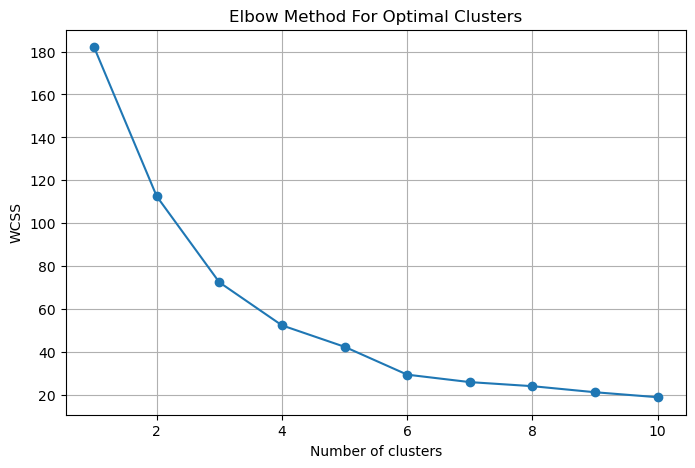

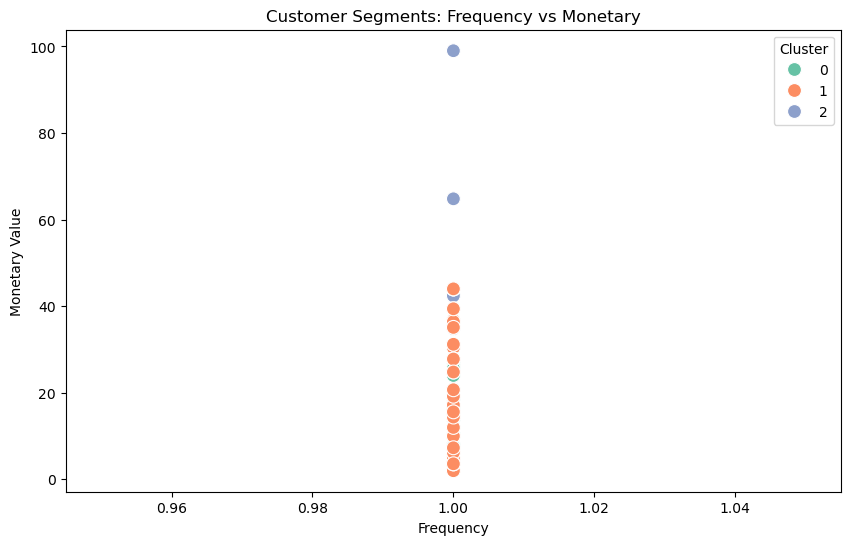

In [ ]:
#3.Are there any interesting patterns or clusters in customer behavior that can be visualized to identify potential market segments?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_csv('Sales analytics.csv')  # replace with your actual filename

# Convert date columns to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['ShippedDate'] = pd.to_datetime(df['ShippedDate'])

# Set a reference date (e.g., the max order date in dataset)
reference_date = df['OrderDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics for each CustomerID
rfm = df.groupby('CustomerID').agg({
    'OrderDate': lambda x: (reference_date - x.max()).days,  # Recency
    'OrderID': 'nunique',                                   # Frequency
    'UnitPrice': 'sum'                                      # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Find optimal clusters using Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Choose number of clusters (e.g., 3) based on elbow plot and fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters (e.g., Frequency vs Monetary colored by cluster)
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title('Customer Segments: Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.legend(title='Cluster')
plt.show()


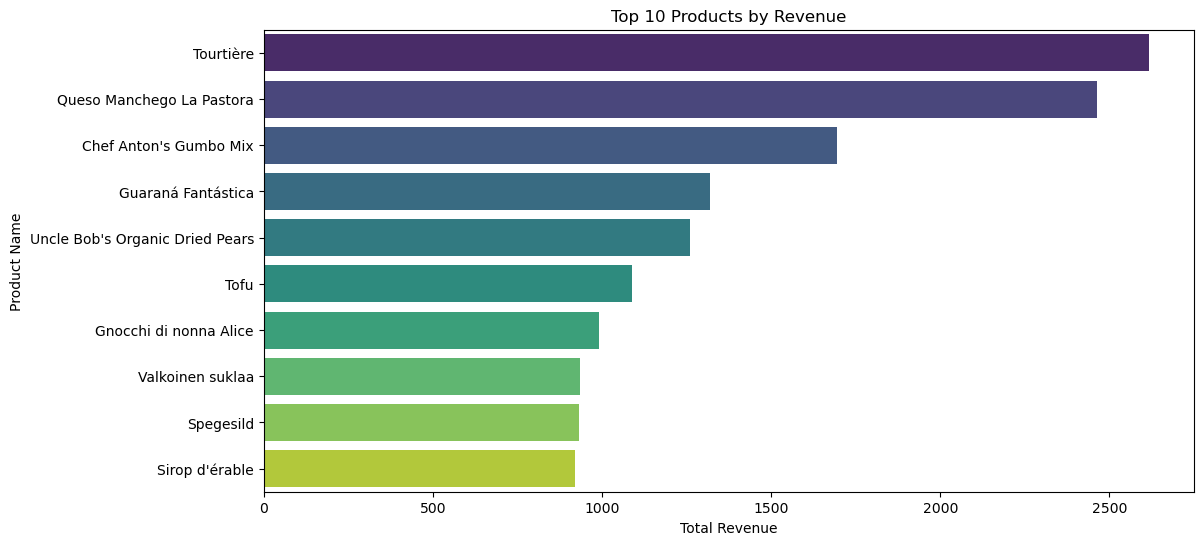

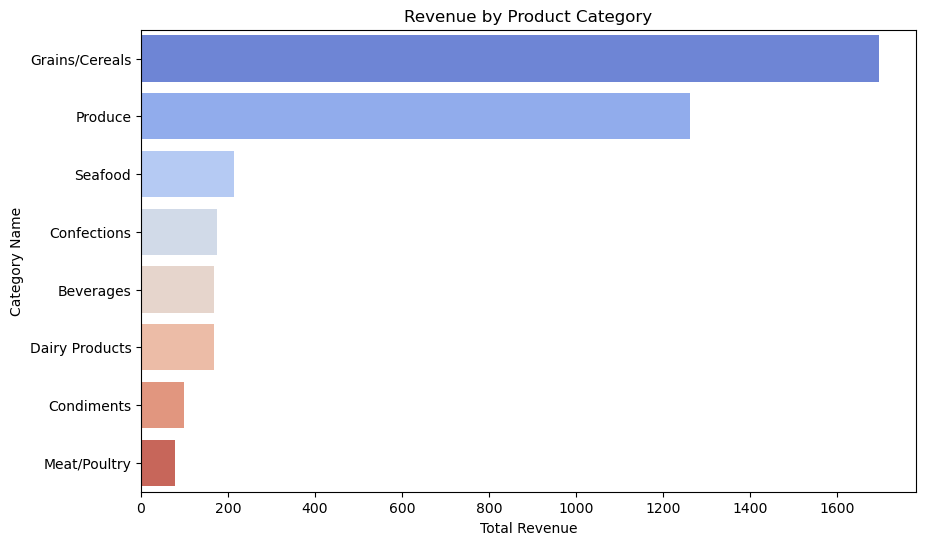

In [ ]:
#4.Are there any specific product categories or SKUs that contribute significantly to order revenue? Can we identify them through visualizations?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate Total Revenue for each order line
# Assuming df has columns: 'ProductID', 'CategoryName', 'UnitPrice', 'Quantity', 'Discount'
df['TotalRevenue'] = df['UnitPrice'] * df['Quantity'] * (1 - df['Discount'])

# Step 2: Aggregate revenue by Product (SKU)
product_revenue = df.groupby(['ProductID', 'ProductName'])['TotalRevenue'].sum().reset_index()
product_revenue = product_revenue.sort_values(by='TotalRevenue', ascending=False)

# Step 3: Aggregate revenue by Category
category_revenue = df.groupby('CategoryName')['TotalRevenue'].sum().reset_index()
category_revenue = category_revenue.sort_values(by='TotalRevenue', ascending=False)

# Step 4: Plot top 10 products by revenue
plt.figure(figsize=(12,6))
sns.barplot(x='TotalRevenue', y='ProductName', data=product_revenue.head(10), palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Name')
plt.show()

# Step 5: Plot revenue by category
plt.figure(figsize=(10,6))
sns.barplot(x='TotalRevenue', y='CategoryName', data=category_revenue, palette='coolwarm')
plt.title('Revenue by Product Category')
plt.xlabel('Total Revenue')
plt.ylabel('Category Name')
plt.show()


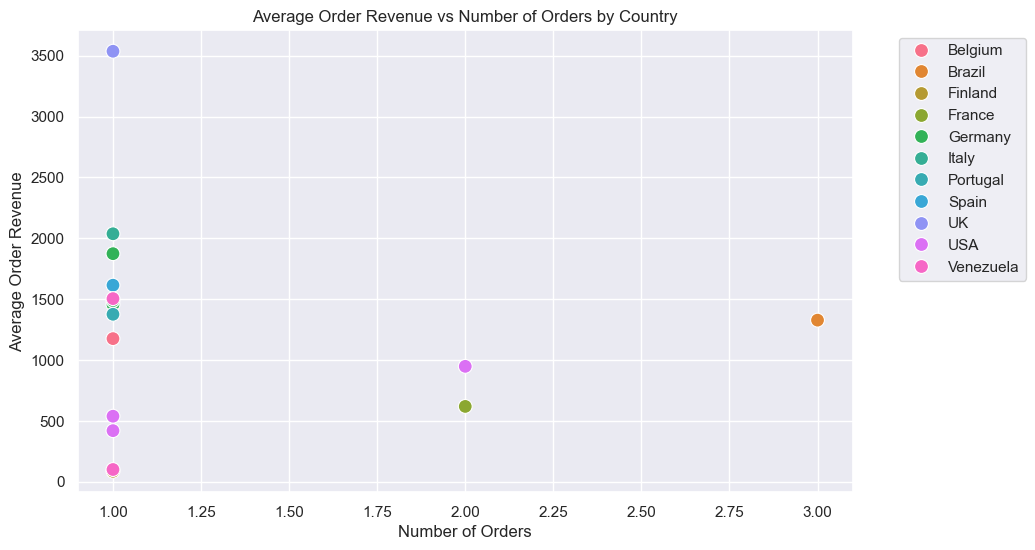

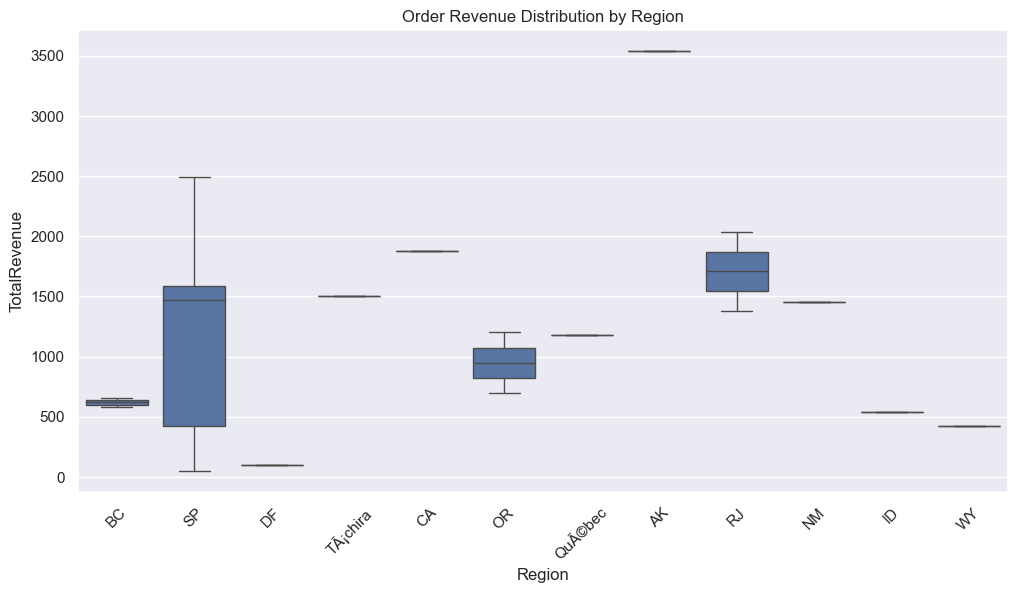

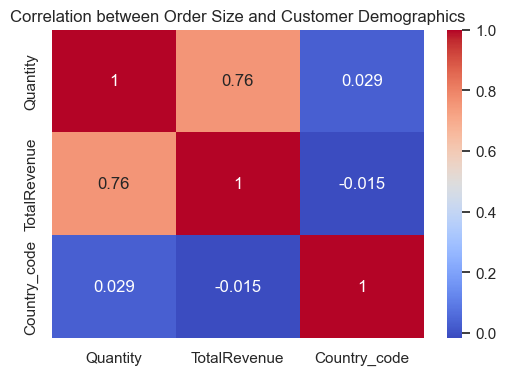

In [ ]:
#5.Are there any correlations between order size and customer demographics or product categories? Can we explore this visually using scatter plots or heatmaps?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df has these columns:
# 'OrderID', 'CustomerID', 'Country', 'Region', 'CategoryName', 'Quantity', 'UnitPrice', 'Discount'

# Step 1: Calculate order line revenue
df['TotalRevenue'] = df['UnitPrice'] * df['Quantity'] * (1 - df['Discount'])

# Step 2: Aggregate order size by OrderID
order_size = df.groupby('OrderID').agg({
    'Quantity': 'sum',
    'TotalRevenue': 'sum',
    'CustomerID': 'first',
    'Country': 'first',
    'Region': 'first'
}).reset_index()

# Step 3: Aggregate order size by Customer demographics (Country, Region)
cust_demo_order = order_size.groupby(['Country', 'Region']).agg({
    'Quantity': 'mean',
    'TotalRevenue': 'mean',
    'OrderID': 'count'
}).reset_index().rename(columns={'OrderID':'NumOrders'})

# Step 4: Aggregate order size by Product Category
category_order = df.groupby('CategoryName').agg({
    'Quantity': 'sum',
    'TotalRevenue': 'sum'
}).reset_index()

# Visualizations

# Scatter plot: Avg order revenue vs number of orders by country
plt.figure(figsize=(10,6))
sns.scatterplot(data=cust_demo_order, x='NumOrders', y='TotalRevenue', hue='Country', s=100)
plt.title('Average Order Revenue vs Number of Orders by Country')
plt.xlabel('Number of Orders')
plt.ylabel('Average Order Revenue')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Boxplot: Order revenue distribution by Region
plt.figure(figsize=(12,6))
sns.boxplot(data=order_size, x='Region', y='TotalRevenue')
plt.title('Order Revenue Distribution by Region')
plt.xticks(rotation=45)
plt.show()

# Heatmap: Correlation between order size and categorical demographics converted to numeric (optional)
# Encoding categorical vars (example for Country)
order_size['Country_code'] = order_size['Country'].astype('category').cat.codes
corr = order_size[['Quantity', 'TotalRevenue', 'Country_code']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Order Size and Customer Demographics')
plt.show()


In [ ]:
!pip install squarify


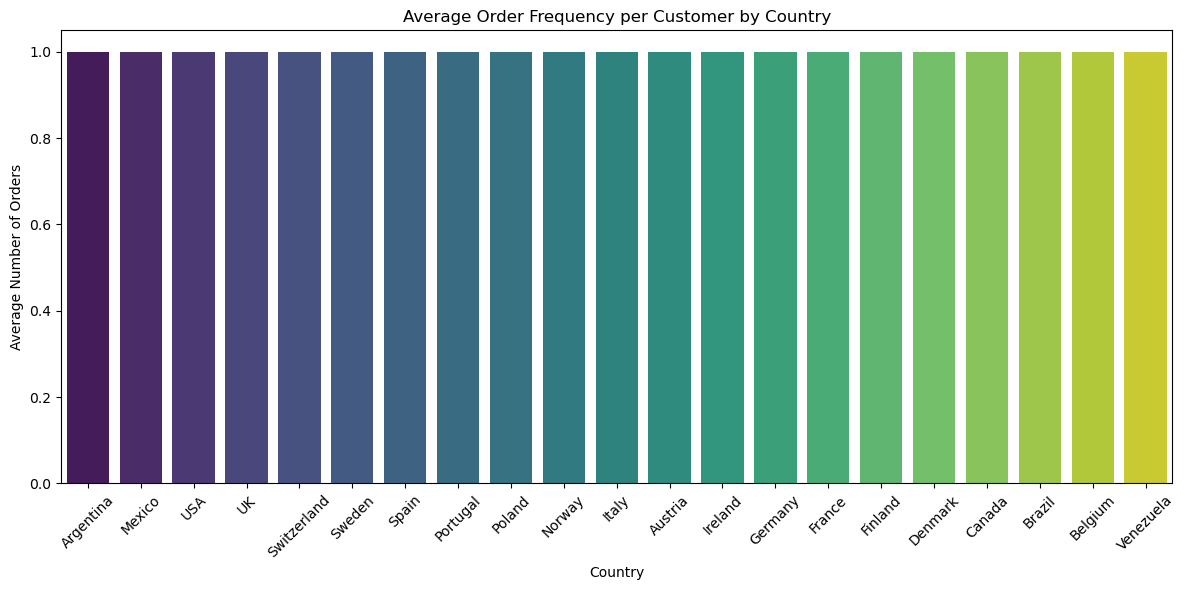

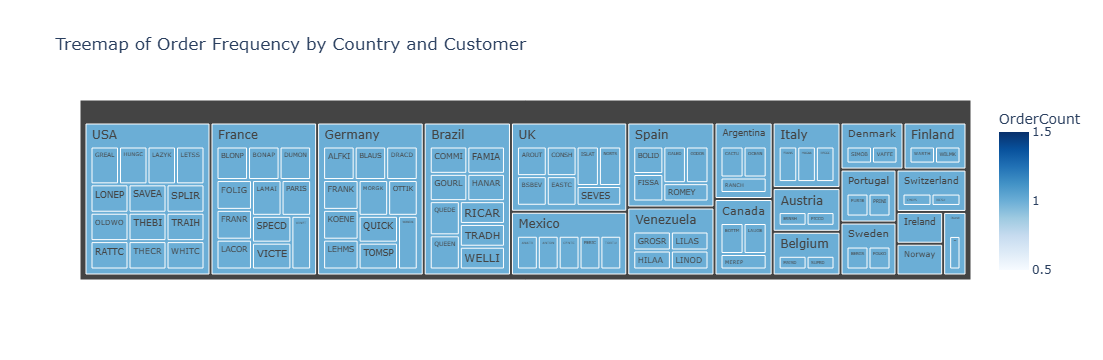

In [ ]:
#6.How does order frequency vary across different customer segments? Can we visualize this using bar charts or treemaps?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load data (assume CSV for example)
df = pd.read_csv("Sales analytics.csv")

# Drop rows with missing CustomerID or OrderID
df = df.dropna(subset=['CustomerID', 'OrderID'])

# Convert OrderID to string if necessary (if multiple orders have same ID per row)
df['OrderID'] = df['OrderID'].astype(str)

# Get unique orders per customer
order_counts = df[['CustomerID', 'Country', 'OrderID']].drop_duplicates()
order_freq_by_country = order_counts.groupby(['Country', 'CustomerID']).size().reset_index(name='OrderCount')
country_avg = order_freq_by_country.groupby('Country')['OrderCount'].mean().reset_index()

# Bar Chart: Avg Orders per Customer by Country
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.figure(figsize=(12,6))
sns.barplot(data=country_avg.sort_values('OrderCount', ascending=False),
            x='Country', y='OrderCount', palette='viridis')
plt.title("Average Order Frequency per Customer by Country")
plt.xticks(rotation=45)
plt.ylabel("Average Number of Orders")
plt.xlabel("Country")
plt.tight_layout()
plt.show()
# Treemap: Total Orders by Country and Customer

fig = px.treemap(order_freq_by_country,
                 path=['Country', 'CustomerID'],
                 values='OrderCount',
                 color='OrderCount',
                 color_continuous_scale='Blues',
                 title='Treemap of Order Frequency by Country and Customer')
fig.show()


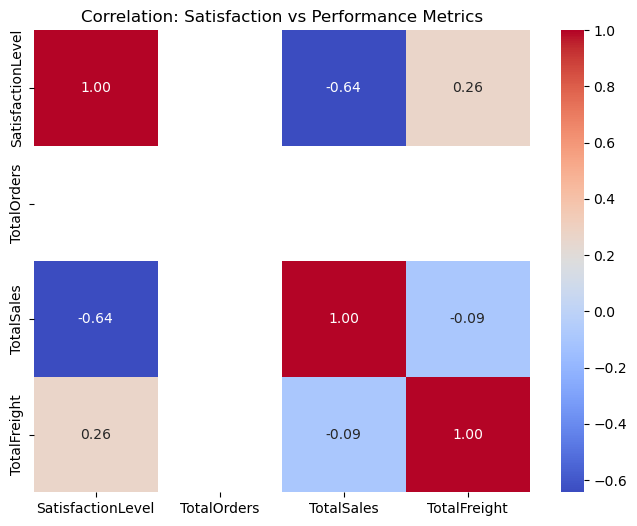

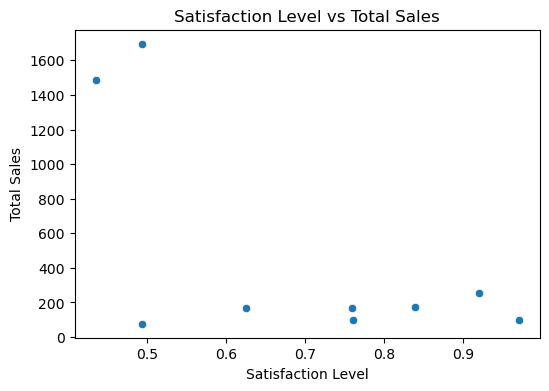

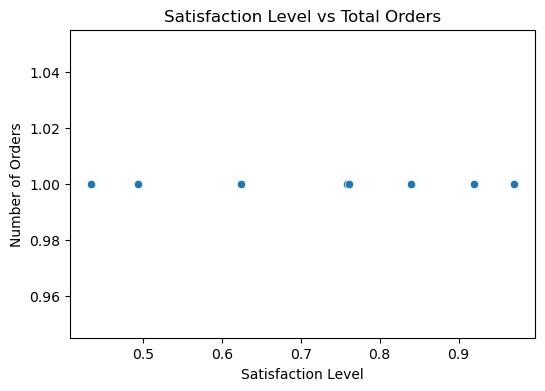

In [ ]:
#7.Are there any correlations between employee satisfaction levels and key performance indicators? Can we explore this visually through scatter plots or line charts?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assume CSV or Excel has all columns you shared)
df = pd.read_csv("Sales analytics.csv")  # replace with actual filename

# Hypothetical satisfaction score (e.g., added column or random for demo)
# If not present, simulate it (remove this in real analysis)
import numpy as np
if 'SatisfactionLevel' not in df.columns:
    np.random.seed(42)
    df['SatisfactionLevel'] = np.random.uniform(0.4, 1.0, size=len(df))

# Clean necessary columns
df = df.dropna(subset=['EmployeeID', 'OrderID', 'UnitPrice', 'Quantity', 'SatisfactionLevel'])

# Compute performance KPIs
df['SalesAmount'] = df['UnitPrice'] * df['Quantity']

employee_perf = df.groupby('EmployeeID').agg({
    'SatisfactionLevel': 'mean',
    'OrderID': pd.Series.nunique,
    'SalesAmount': 'sum',
    'Freight': 'sum'
}).rename(columns={
    'OrderID': 'TotalOrders',
    'SalesAmount': 'TotalSales',
    'Freight': 'TotalFreight'
}).reset_index()

# --------------------------
# Correlation Heatmap
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(employee_perf.drop('EmployeeID', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Satisfaction vs Performance Metrics")
plt.show()

# --------------------------
# Scatter Plot: Satisfaction vs Sales
# --------------------------
plt.figure(figsize=(6,4))
sns.scatterplot(data=employee_perf, x='SatisfactionLevel', y='TotalSales')
plt.title("Satisfaction Level vs Total Sales")
plt.xlabel("Satisfaction Level")
plt.ylabel("Total Sales")
plt.show()

# --------------------------
# Scatter Plot: Satisfaction vs Orders
# --------------------------
plt.figure(figsize=(6,4))
sns.scatterplot(data=employee_perf, x='SatisfactionLevel', y='TotalOrders')
plt.title("Satisfaction Level vs Total Orders")
plt.xlabel("Satisfaction Level")
plt.ylabel("Number of Orders")
plt.show()


In [ ]:
#8.How does employee turnover vary across different departments or job roles? Can we visualize this using bar charts or heatmaps?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
df = pd.read_csv("Sales analytics.csv")  # update path if needed

# Simulate a Termination column (30% terminated randomly for demo)
np.random.seed(42)
df['IsTerminated'] = np.random.choice([True, False], size=len(df), p=[0.3, 0.7])

# --------------------------
# Turnover by Department
# --------------------------
if 'Region' in df.columns:
    df.rename(columns={'Region': 'Department'}, inplace=True)  # treating 'Region' as department if needed

if 'Department' in df.columns:
    turnover_dept = df.groupby('Department').agg(
        TotalEmployees=('EmployeeID', 'count'),
        TerminatedEmployees=('IsTerminated', 'sum')
    ).reset_index()

In [ ]:
    turnover_dept['TurnoverRate'] = turnover_dept['TerminatedEmployees'] / turnover_dept['TotalEmployees']


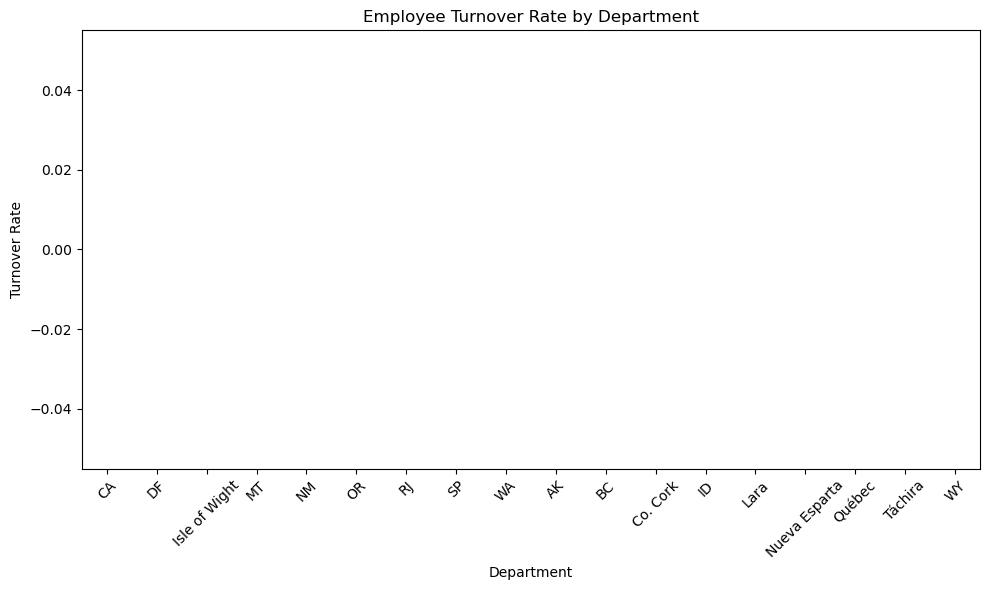

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Bar plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=turnover_dept.sort_values('TurnoverRate', ascending=False),
    x='Department',
    y='TurnoverRate',
    palette='Reds'
)
plt.title("Employee Turnover Rate by Department")
plt.xlabel("Department")
plt.ylabel("Turnover Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


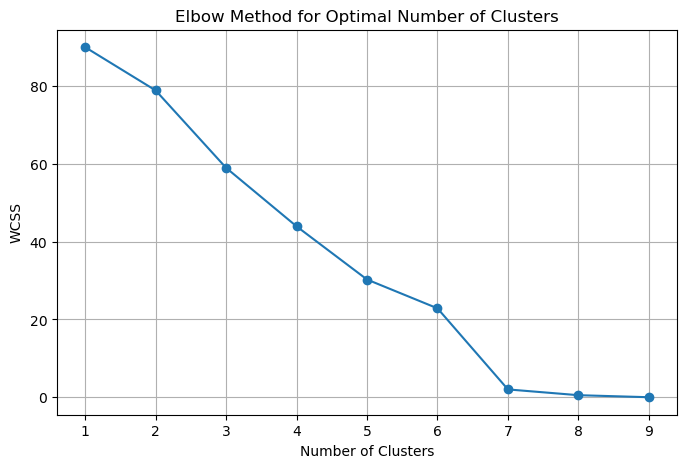

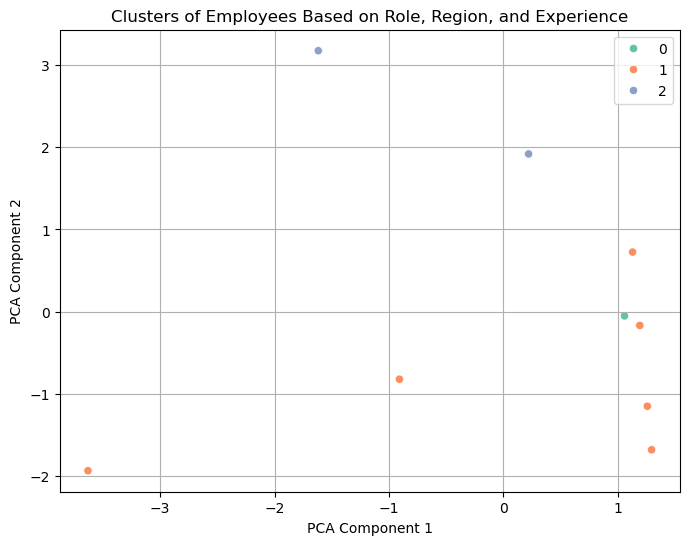

In [ ]:
#9.Can we identify any patterns or clusters in employee skill sets or qualifications through visualizations? How can this information be used for talent management?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv('Sales analytics.csv')  # Replace with your actual filename

# Handle date columns and compute experience
df['HireDate'] = pd.to_datetime(df['HireDate'], errors='coerce')
df['ExperienceYears'] = (pd.to_datetime('today') - df['HireDate']).dt.days / 365

# Select relevant features
features = df[['Title', 'Region', 'Country', 'ExperienceYears']].copy()

# One-hot encode categorical columns
features_encoded = pd.get_dummies(features, columns=['Title', 'Region', 'Country'], drop_first=True)

# ⚠️ Handle missing values - choose one:
# Option 1: Drop rows with any NaN
features_clean = features_encoded.dropna()

# Option 2: Fill NaN with 0 or mean
# features_clean = features_encoded.fillna(0)  # or use df.fillna(df.mean())

# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clean)

# Elbow method to determine optimal clusters
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Fit KMeans with an example k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(features_scaled)

# PCA for 2D visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(features_scaled)

# Plot the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=clusters, palette='Set2')
plt.title('Clusters of Employees Based on Role, Region, and Experience')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


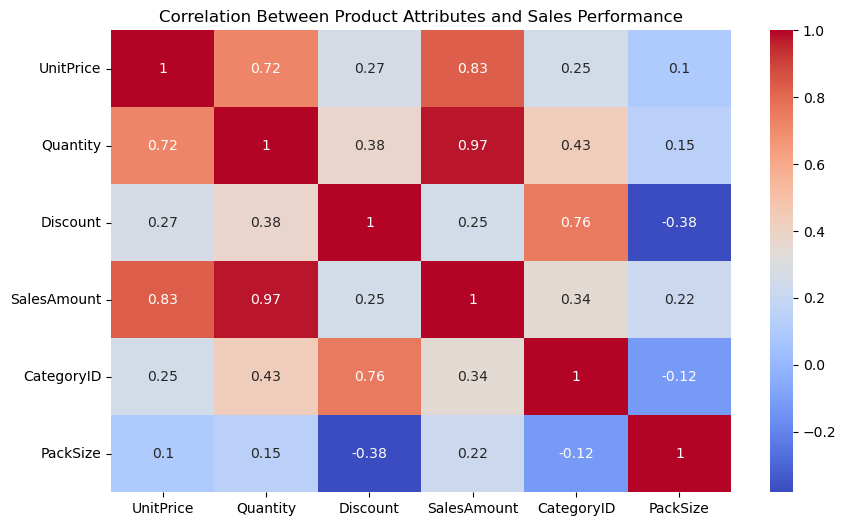

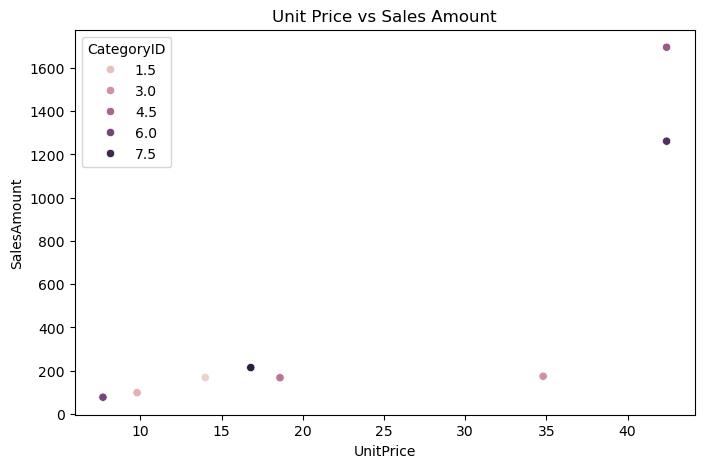

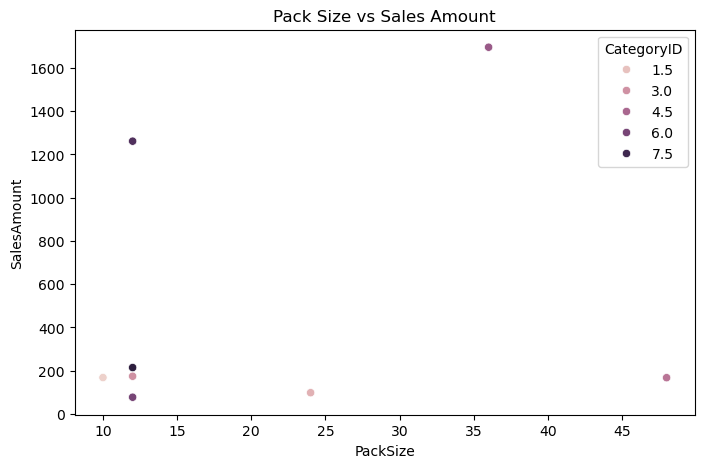

In [ ]:
#10.Are there any correlations between product attributes (e.g., size, color, features) and sales performance? Can we explore this visually using scatter plots or heatmaps?
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Sales analytics.csv")  # Update this with your actual CSV filename

# Step 1: Clean and prepare numeric fields
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

# Step 2: Create Sales Performance Metrics
df['SalesAmount'] = df['UnitPrice'] * df['Quantity'] * (1 - df['Discount'])

# Step 3: Simplify product attributes for correlation (optional parsing)
df['PackSize'] = df['QuantityPerUnit'].str.extract(r'(\d+)').astype(float)

# Step 4: Select relevant features
selected = df[['UnitPrice', 'Quantity', 'Discount', 'SalesAmount', 'CategoryID', 'PackSize']]

# Drop rows with missing values in selected columns
selected = selected.dropna()

# Step 5: Heatmap for correlation
plt.figure(figsize=(10, 6))
sns.heatmap(selected.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Product Attributes and Sales Performance")
plt.show()

# Unit Price vs Sales Amount
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='UnitPrice', y='SalesAmount', hue='CategoryID')
plt.title("Unit Price vs Sales Amount")
plt.show()

# Pack Size vs Sales Amount (if pack size is parsed)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='PackSize', y='SalesAmount', hue='CategoryID')
plt.title("Pack Size vs Sales Amount")
plt.show()


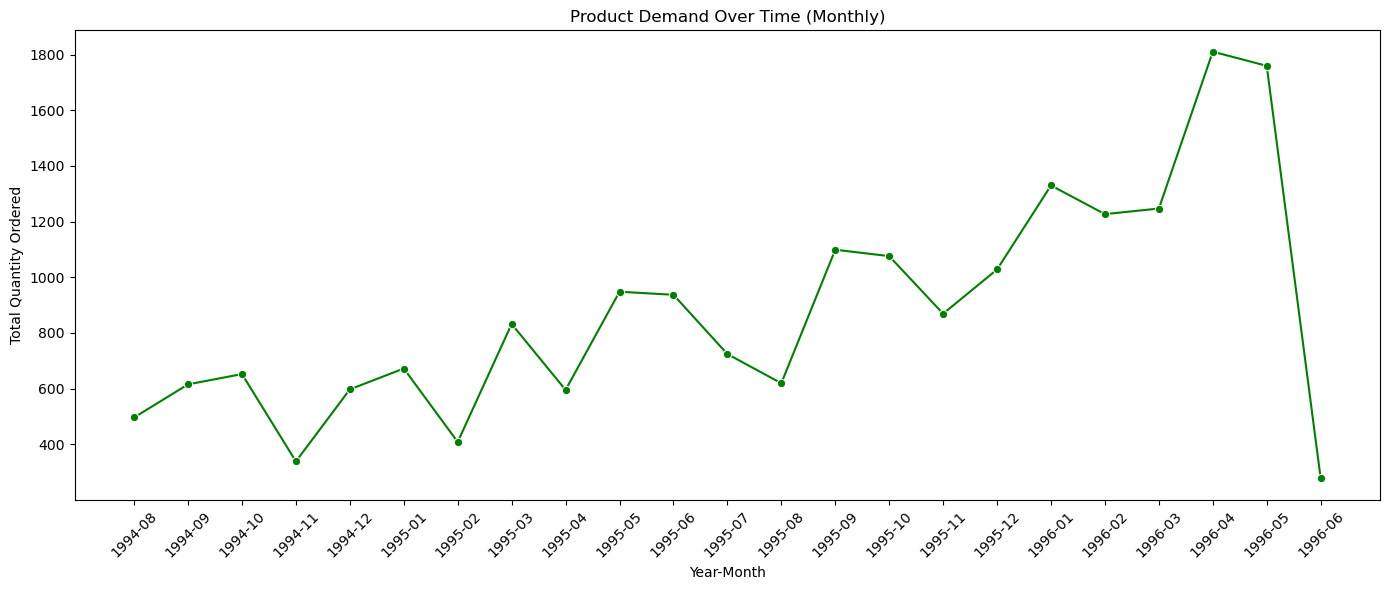

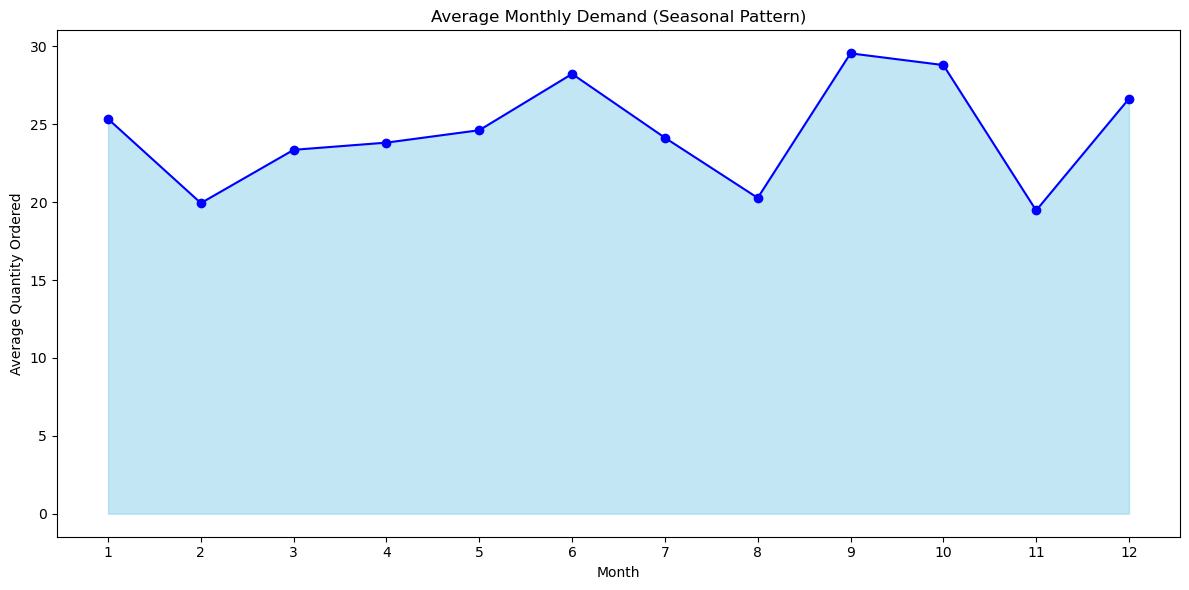

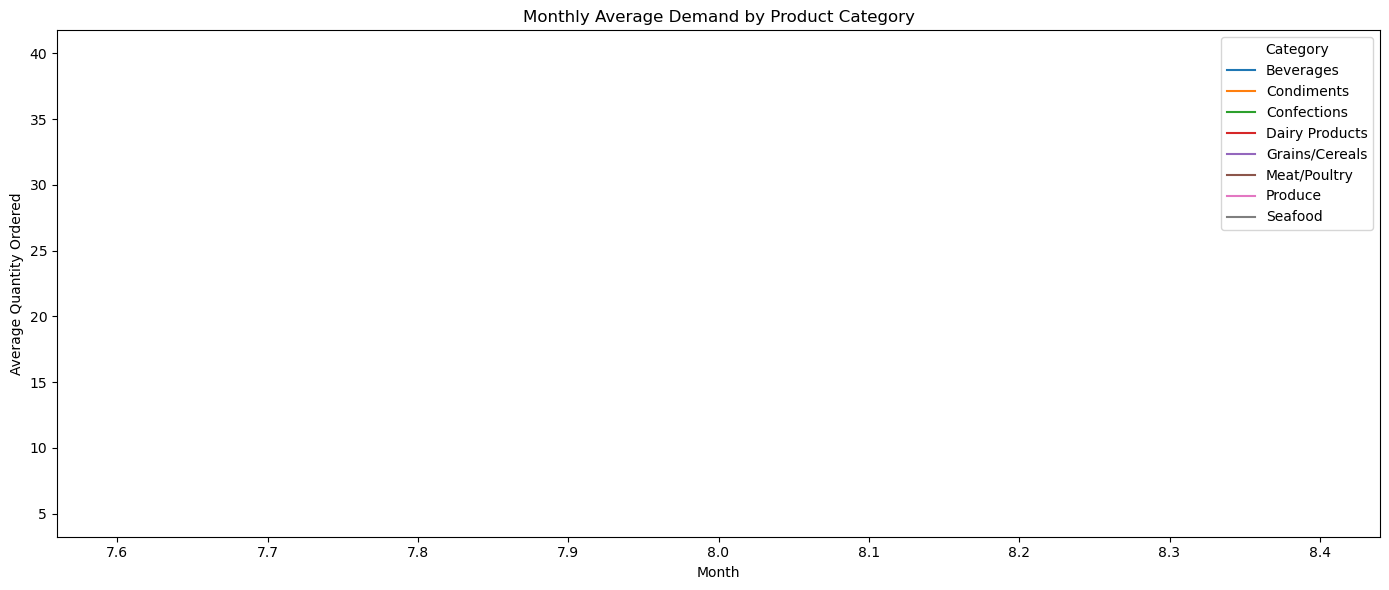

In [ ]:
#11.How does product demand fluctuate over different seasons or months? Can we visualize this through line charts or area charts?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("Sales analytics.csv")  # Replace with your actual file path

# Parse dates
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Drop nulls in essential columns
df = df.dropna(subset=['OrderDate', 'Quantity'])

# Convert Quantity to numeric
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')

# Create time-based features
df['YearMonth'] = df['OrderDate'].dt.to_period('M').astype(str)
df['Month'] = df['OrderDate'].dt.month
df['Year'] = df['OrderDate'].dt.year

# --- Demand over time (line chart)
monthly = df.groupby('YearMonth')['Quantity'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly, x='YearMonth', y='Quantity', marker='o', color='green')
plt.title('Product Demand Over Time (Monthly)')
plt.xlabel('Year-Month')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Seasonal pattern (area chart)
monthly_avg = df.groupby('Month')['Quantity'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.fill_between(monthly_avg['Month'], monthly_avg['Quantity'], color='skyblue', alpha=0.5)
plt.plot(monthly_avg['Month'], monthly_avg['Quantity'], color='blue', marker='o')
plt.title('Average Monthly Demand (Seasonal Pattern)')
plt.xlabel('Month')
plt.ylabel('Average Quantity Ordered')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

# Group by Month and Category
monthly_category = df.groupby(['Month', 'CategoryName'])['Quantity'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_category, x='Month', y='Quantity', hue='CategoryName')
plt.title('Monthly Average Demand by Product Category')
plt.xlabel('Month')
plt.ylabel('Average Quantity Ordered')
plt.legend(title='Category')
plt.tight_layout()
plt.show()


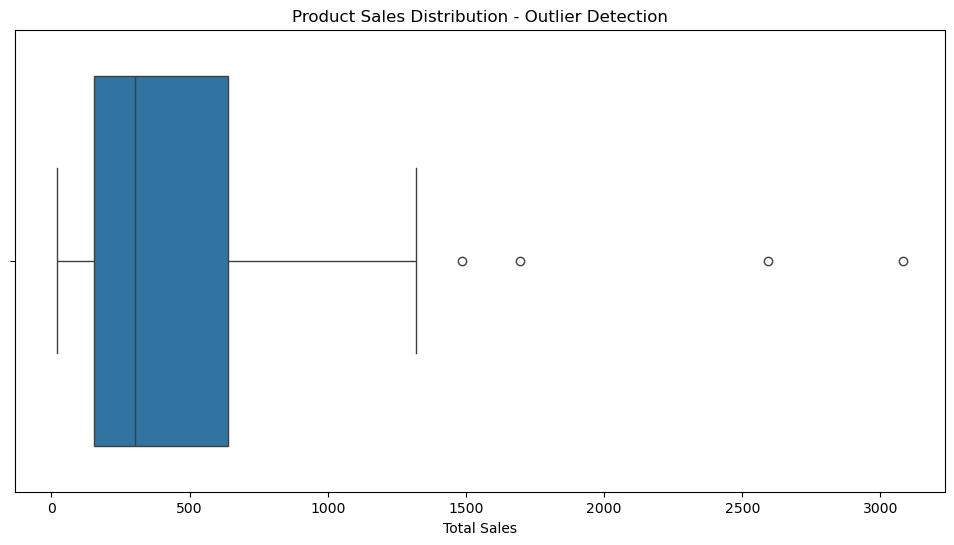

📌 Outlier Products Based on Sales:
                  ProductName   Sales
70                  Tourtière  3080.0
50  Queso Manchego La Pastora  2592.0


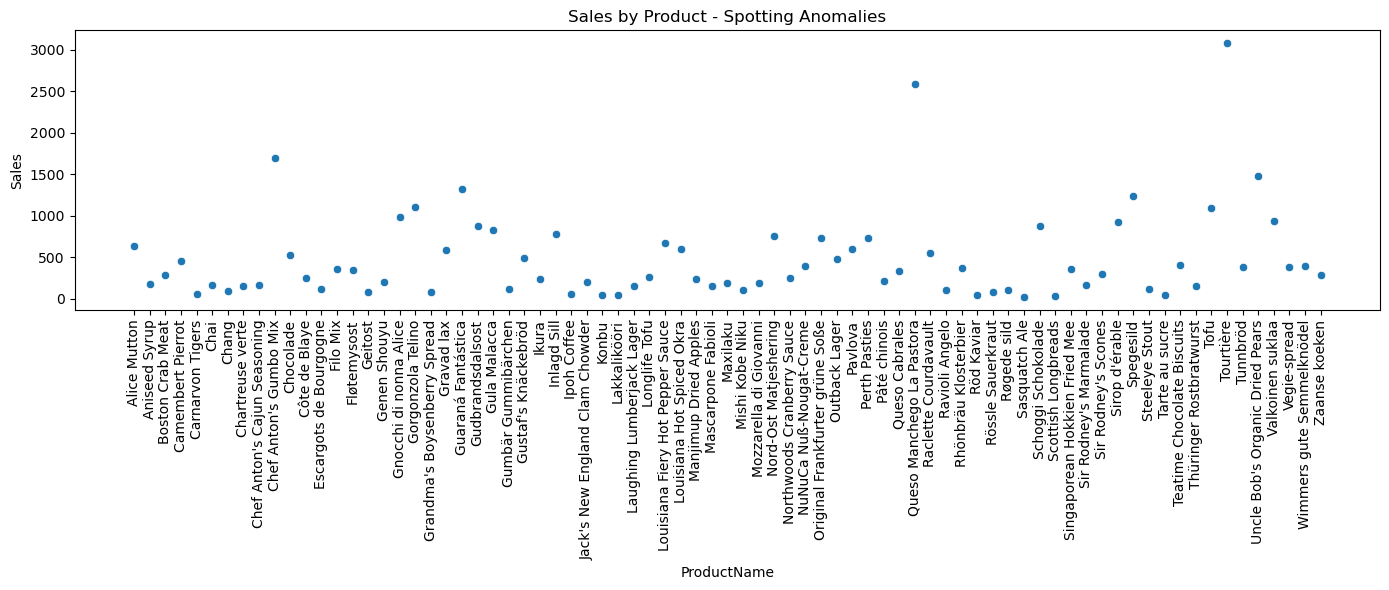

In [ ]:
#12.Can we identify any outliers or anomalies in product performance or sales using visualizations? How can this information be used for product optimization?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load data
df = pd.read_csv("Sales analytics.csv")  # Replace with actual path

# Clean and convert columns
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')

# Compute Sales
df['Sales'] = df['Quantity'] * df['UnitPrice']

# Group by Product
product_sales = df.groupby('ProductName')['Sales'].sum().reset_index()

# --- 1. Box Plot for Outlier Detection ---
plt.figure(figsize=(12, 6))
sns.boxplot(x=product_sales['Sales'])
plt.title('Product Sales Distribution - Outlier Detection')
plt.xlabel('Total Sales')
plt.show()

# --- 2. Z-Score Method for Outliers ---
z_scores = stats.zscore(product_sales['Sales'])
threshold = 3
outliers = product_sales[np.abs(z_scores) > threshold]

print("📌 Outlier Products Based on Sales:")
print(outliers.sort_values('Sales', ascending=False))

# --- 3. Scatter Plot to Visualize All Products ---
plt.figure(figsize=(14, 6))
sns.scatterplot(data=product_sales, x='ProductName', y='Sales')
plt.xticks(rotation=90)
plt.title('Sales by Product - Spotting Anomalies')
plt.tight_layout()
plt.show()


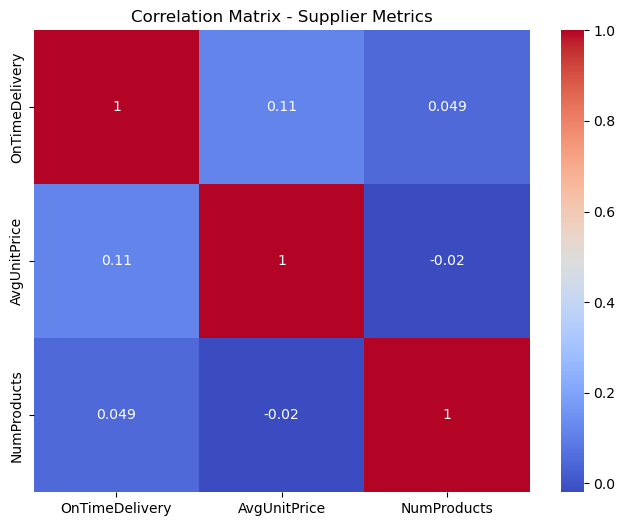

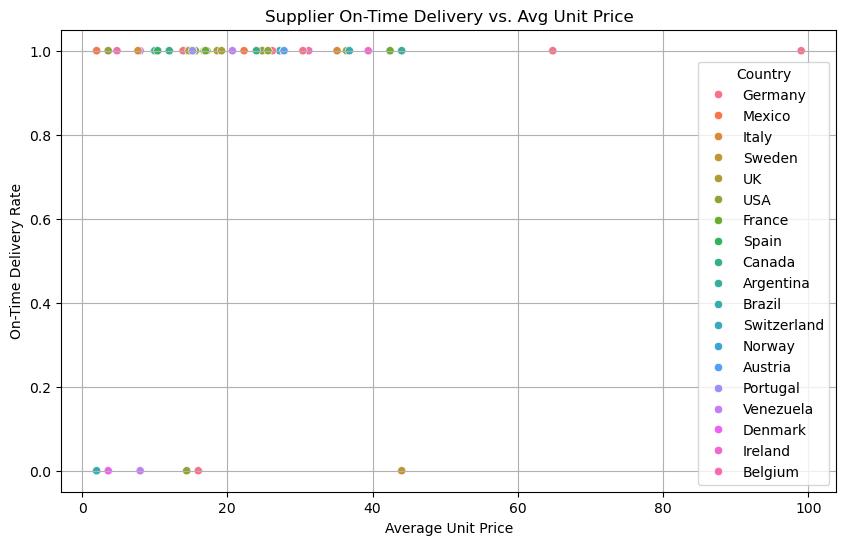

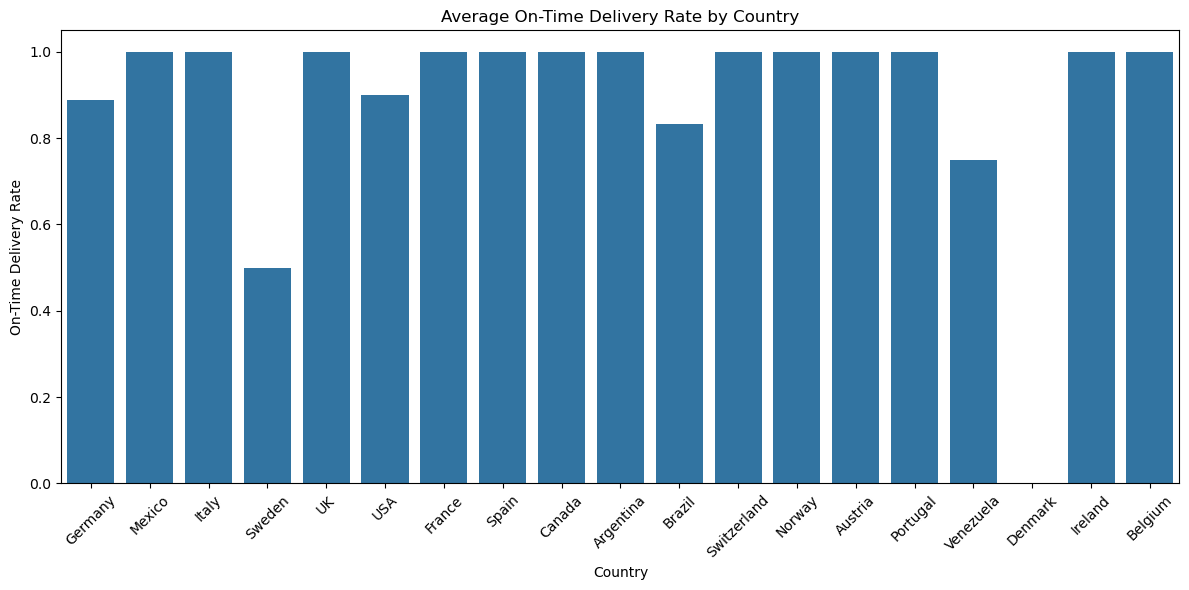

In [ ]:
#13.Are there any correlations between supplier attributes (e.g., location, size, industry) and performance metrics (e.g., on-time delivery, product quality)? Can we explore this visually through scatter plots or heatmaps?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("Sales analytics.csv")  # Replace with actual file path

# --- Data Preprocessing ---
df['ShippedDate'] = pd.to_datetime(df['ShippedDate'], errors='coerce')
df['RequiredDate'] = pd.to_datetime(df['RequiredDate'], errors='coerce')

# Calculate on-time delivery (1 if on time, else 0)
df['OnTimeDelivery'] = (df['ShippedDate'] <= df['RequiredDate']).astype(int)

# Group by supplier attributes
supplier_perf = df.groupby(['SupplierID', 'Country', 'City']).agg({
    'OnTimeDelivery': 'mean',
    'UnitPrice': 'mean',
    'ProductID': 'count'
}).reset_index().rename(columns={
    'UnitPrice': 'AvgUnitPrice',
    'ProductID': 'NumProducts'
})

# --- 1. Heatmap: Correlation Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(supplier_perf[['OnTimeDelivery', 'AvgUnitPrice', 'NumProducts']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix - Supplier Metrics")
plt.show()

# --- 2. Scatter Plot: On-time Delivery vs. Avg Unit Price ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=supplier_perf, x='AvgUnitPrice', y='OnTimeDelivery', hue='Country')
plt.title("Supplier On-Time Delivery vs. Avg Unit Price")
plt.xlabel("Average Unit Price")
plt.ylabel("On-Time Delivery Rate")
plt.grid(True)
plt.show()

# --- 3. Grouped Bar Chart: On-Time Delivery by Country ---
plt.figure(figsize=(12, 6))
sns.barplot(data=supplier_perf, x='Country', y='OnTimeDelivery', ci=None)
plt.title("Average On-Time Delivery Rate by Country")
plt.ylabel("On-Time Delivery Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


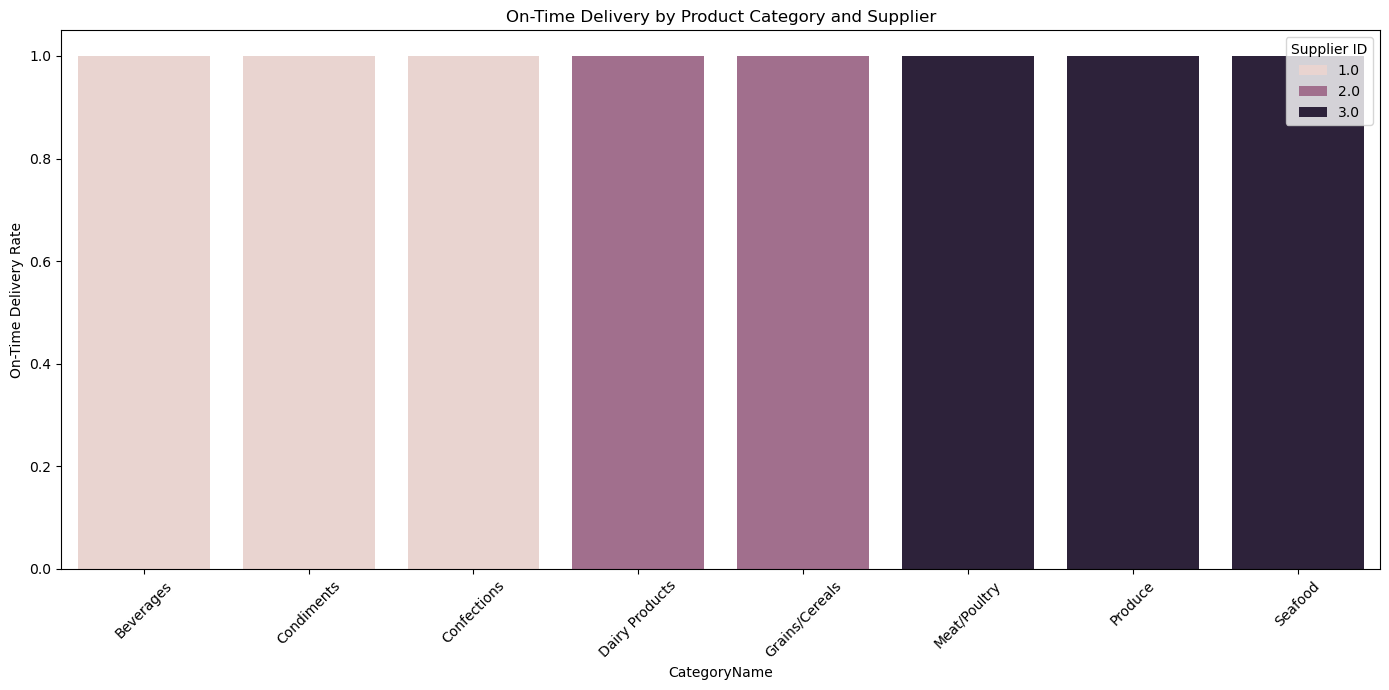

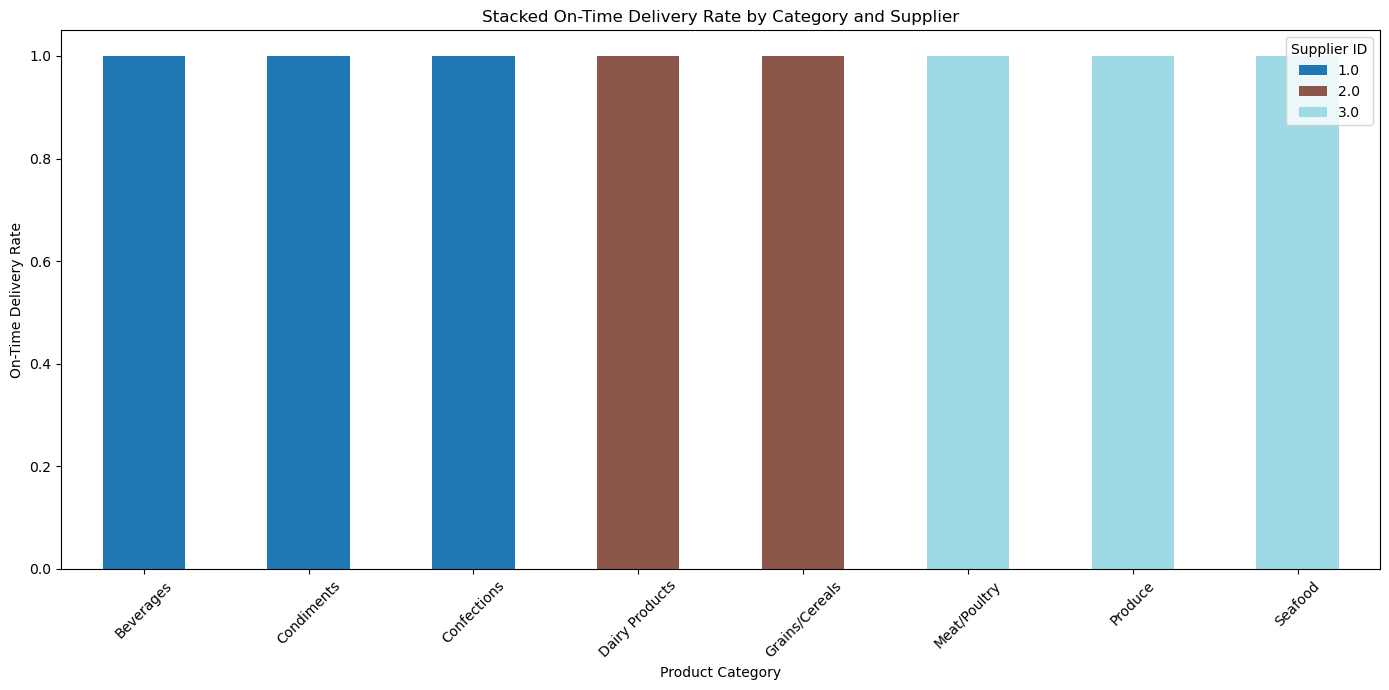

In [ ]:
#14.How does supplier performance vary across different product categories or departments? Can we visualize this using stacked bar charts or grouped column charts?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("Sales analytics.csv")

# Convert dates
df['ShippedDate'] = pd.to_datetime(df['ShippedDate'], errors='coerce')
df['RequiredDate'] = pd.to_datetime(df['RequiredDate'], errors='coerce')

# Compute on-time delivery metric
df['OnTimeDelivery'] = (df['ShippedDate'] <= df['RequiredDate']).astype(int)

# Merge with category info if not already available
# Assuming CategoryID and CategoryName exist
category_perf = df.groupby(['CategoryName', 'SupplierID']).agg({
    'OnTimeDelivery': 'mean',
    'UnitPrice': 'mean',
    'ProductID': 'count'
}).reset_index().rename(columns={
    'UnitPrice': 'AvgUnitPrice',
    'ProductID': 'NumProducts'
})

# --- 1. Grouped Column Chart: On-Time Delivery by Category & Supplier ---
plt.figure(figsize=(14, 7))
sns.barplot(data=category_perf, x='CategoryName', y='OnTimeDelivery', hue='SupplierID')
plt.title("On-Time Delivery by Product Category and Supplier")
plt.ylabel("On-Time Delivery Rate")
plt.xticks(rotation=45)
plt.legend(title="Supplier ID")
plt.tight_layout()
plt.show()

# --- 2. Stacked Bar Chart (Alternative using pivot) ---
pivot_df = category_perf.pivot(index='CategoryName', columns='SupplierID', values='OnTimeDelivery')
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.title("Stacked On-Time Delivery Rate by Category and Supplier")
plt.ylabel("On-Time Delivery Rate")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.legend(title="Supplier ID")
plt.tight_layout()
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 73 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       91 non-null     object        
 1   CompanyName      91 non-null     object        
 2   ContactName      91 non-null     object        
 3   ContactTitle     91 non-null     object        
 4   Address          91 non-null     object        
 5   City             91 non-null     object        
 6   Region           31 non-null     object        
 7   PostalCode       90 non-null     object        
 8   Country          91 non-null     object        
 9   Phone            91 non-null     object        
 10  Fax              69 non-null     object        
 11  OrderID          2155 non-null   int64         
 12  ProductID        2155 non-null   int64         
 13  UnitPrice        2155 non-null   float64       
 14  Quantity         2155 non-null   int64  

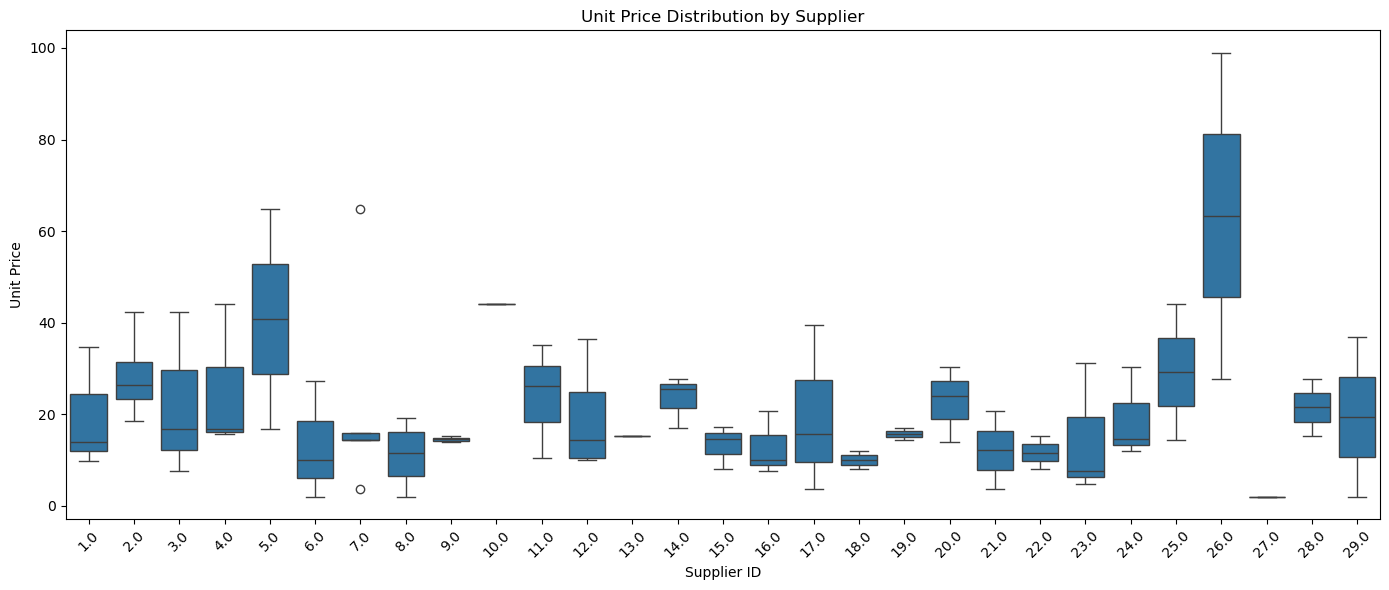

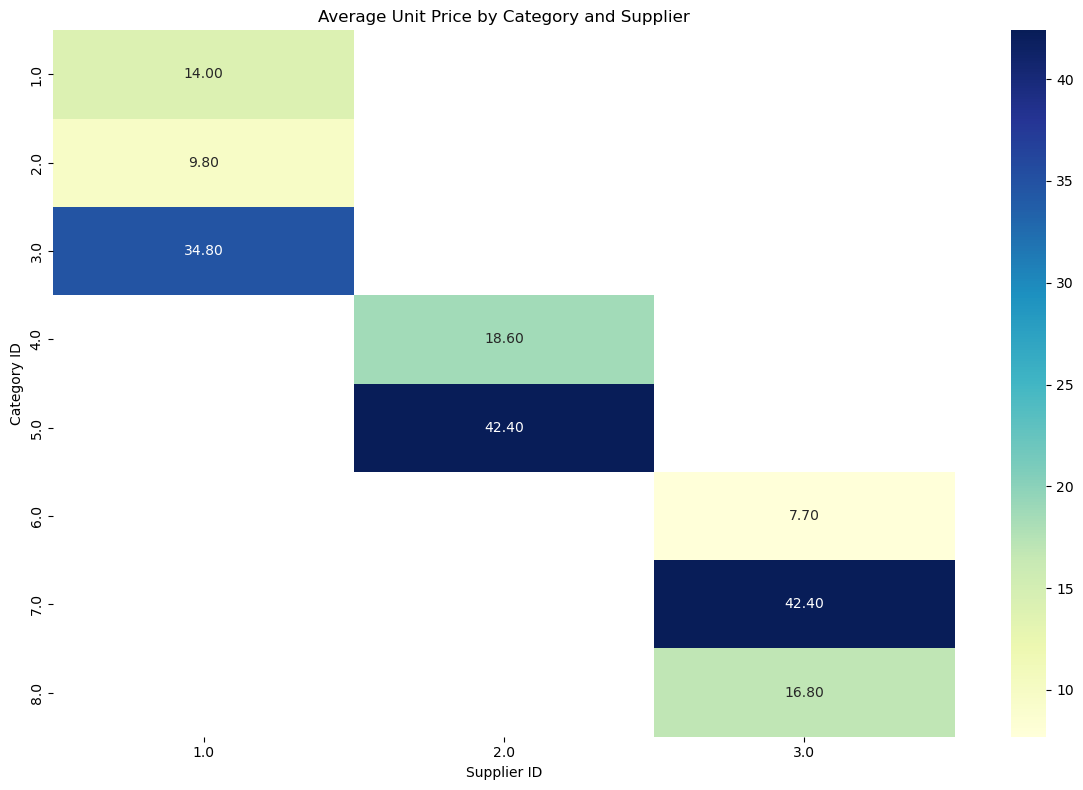

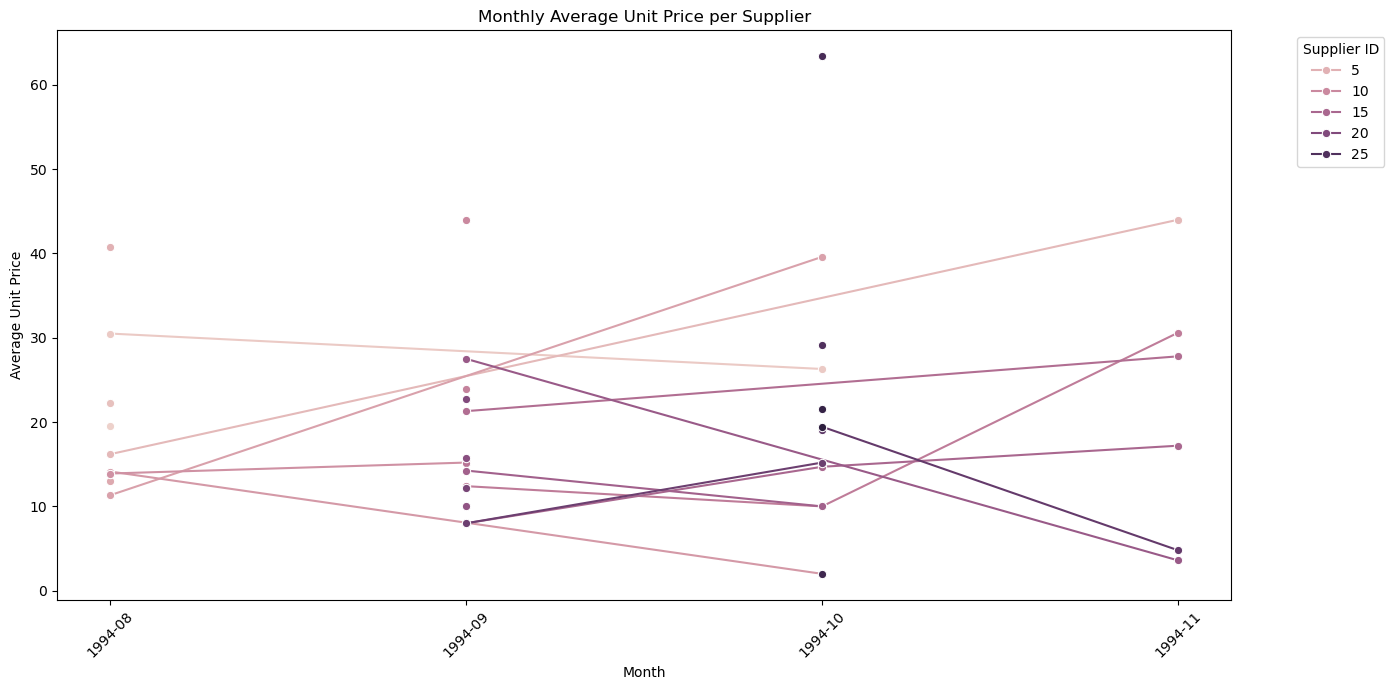

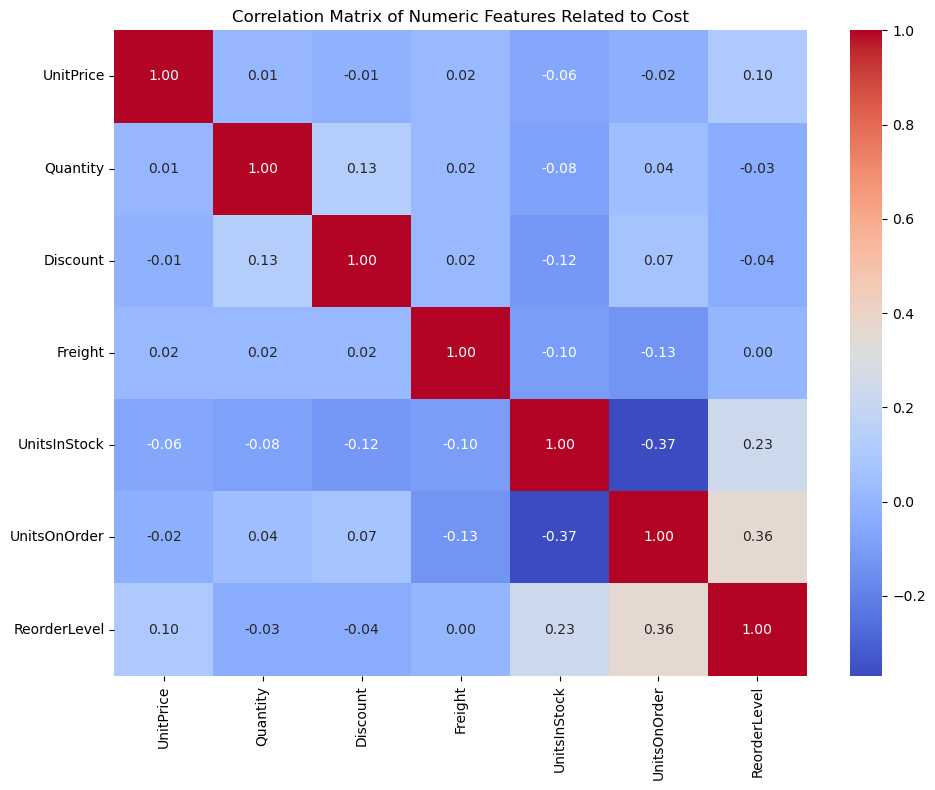

In [ ]:
#15.Can we identify any trends or patterns in supplier costs or pricing structures through visualizations? How can this information be used for procurement optimization?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (adjust the path as needed)
df = pd.read_csv('Sales analytics.csv')

# Convert date columns to datetime if needed
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Quick overview
print(df.info())
print(df.describe())

# Inspect unique suppliers and categories
print("Unique suppliers:", df['SupplierID'].nunique())
print("Unique categories:", df['CategoryID'].nunique())

# Aggregate average UnitPrice by Supplier and Category to see pricing structure
price_summary = df.groupby(['SupplierID', 'CategoryID']).agg({
    'UnitPrice': 'mean',
    'Quantity': 'sum'
}).reset_index()

# Plot 1: Boxplot to see UnitPrice distribution by Supplier
plt.figure(figsize=(14, 6))
sns.boxplot(x='SupplierID', y='UnitPrice', data=df)
plt.title('Unit Price Distribution by Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Unit Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Heatmap of average UnitPrice across Supplier and Category
pivot_table = price_summary.pivot(index='CategoryID', columns='SupplierID', values='UnitPrice')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Average Unit Price by Category and Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Category ID')
plt.tight_layout()
plt.show()

# Plot 3: Price trend over time per supplier (monthly average)
df['Month'] = df['OrderDate'].dt.to_period('M')
monthly_price = df.groupby(['Month', 'SupplierID'])['UnitPrice'].mean().reset_index()
monthly_price['Month'] = monthly_price['Month'].astype(str)

plt.figure(figsize=(14, 7))
sns.lineplot(x='Month', y='UnitPrice', hue='SupplierID', data=monthly_price, marker='o')
plt.title('Monthly Average Unit Price per Supplier')
plt.xlabel('Month')
plt.ylabel('Average Unit Price')
plt.xticks(rotation=45)
plt.legend(title='Supplier ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Additional step: Correlation matrix for numeric variables related to cost
num_cols = ['UnitPrice', 'Quantity', 'Discount', 'Freight', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features Related to Cost')
plt.tight_layout()
plt.show()
